# Competition - The Bakery Delivery Route

Management Science - Artisan Bakery

# Client Briefing: Artisan Bakery

## The Morning Delivery Crisis

**Master Baker’s Message:**

*“Every morning at 5 AM, our delivery van leaves with fresh bread for 12
cafés across the city. Our driver currently takes over 3 hours using his
‘intuition’ for the route. The fuel costs are killing us, and worse,
some cafés get their bread late.*

*Three of our premium clients open early at 6:30 AM and absolutely MUST
have their bread by then. The others open at 7:00 AM or later. We’re
spending €80+ daily in excess fuel and labor costs. That’s €29,200 per
year!*

*Can you optimize our morning delivery route? We need a solution that
handles our early-bird cafés and minimizes total distance. Help us
deliver happiness more efficiently!“*

## The Challenge

### Your Mission

Design an optimal delivery route for Artisan Bakery that: 1. Visits all
12 cafés exactly once 2. Prioritizes 3 early-opening cafés (must arrive
by 6:30 AM) 3. Minimizes total distance traveled 4. Returns to the
bakery

### Business Context

-   **Current situation:** 3+ hours, driver’s intuition, frequent late
    deliveries
-   **Cost structure:**
    -   Fuel: €1.80 per km
    -   Driver: €35 per hour
    -   Late penalty: €50 per late delivery (damages reputation)
-   **Vehicle:** One delivery van, 40 km/h average speed in morning
    traffic

### Success Metrics

Your solution will be evaluated on: 1. **Total distance** (primary
metric) 2. **Time window compliance** (meeting early café deadlines) 3.
**Solution quality** vs. other teams 4. **Presentation clarity** (can
the driver understand it?)

## Data & Starter Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta

# Set seed for consistency across all teams
np.random.seed(2025)

# Bakery location (city center)
bakery_location = (5.0, 5.0)

# 12 Café locations (x, y) in kilometers from city origin
cafe_locations = [
    (2.1, 8.3),   # Café 1: Sunrise Bistro (EARLY - 6:30 AM)
    (7.8, 9.2),   # Café 2: The Daily Grind
    (9.5, 6.1),   # Café 3: Café Europa (EARLY - 6:30 AM)
    (8.4, 2.3),   # Café 4: Corner Coffee
    (4.6, 1.1),   # Café 5: South Side Café
    (1.3, 1.8),   # Café 6: West End Espresso
    (0.7, 4.9),   # Café 7: Riverside Roast
    (1.9, 7.1),   # Café 8: Morning Glory (EARLY - 6:45 AM)
    (3.8, 8.9),   # Café 9: Hilltop Haven
    (6.2, 7.4),   # Café 10: Central Perk
    (7.1, 4.2),   # Café 11: Midtown Munch
    (3.3, 3.7),   # Café 12: Old Town Oven
]

# Café names and opening times
cafe_info = pd.DataFrame({
    'cafe_id': range(1, 13),
    'name': [
        'Sunrise Bistro', 'The Daily Grind', 'Café Europa', 'Corner Coffee',
        'South Side Café', 'West End Espresso', 'Riverside Roast', 'Morning Glory',
        'Hilltop Haven', 'Central Perk', 'Midtown Munch', 'Old Town Oven'
    ],
    'x': [loc[0] for loc in cafe_locations],
    'y': [loc[1] for loc in cafe_locations],
    'opening_time': [
        '06:30', '07:00', '06:30', '07:15',  # Cafés 1-4
        '07:30', '07:00', '07:00', '06:45',  # Cafés 5-8
        '07:15', '07:00', '07:30', '07:00'   # Cafés 9-12
    ],
    'time_window': [
        'EARLY', 'Regular', 'EARLY', 'Regular',  # Cafés 1-4
        'Regular', 'Regular', 'Regular', 'EARLY',  # Cafés 5-8
        'Regular', 'Regular', 'Regular', 'Regular'  # Cafés 9-12
    ]
})

# Display the café information
print("CAFÉ INFORMATION:")
print("=" * 60)
print(cafe_info.to_string(index=False))
print("\n" + "=" * 60)
print(f"Bakery location: {bakery_location}")
print(f"Departure time: 5:00 AM")
print(f"Average speed: 40 km/h")
print("\nEARLY cafés (must arrive before opening):")
for _, row in cafe_info[cafe_info['time_window'] == 'EARLY'].iterrows():
    print(f"  - {row['name']} (Café {row['cafe_id']}): Opens at {row['opening_time']}")

CAFÉ INFORMATION:
 cafe_id              name   x   y opening_time time_window
       1    Sunrise Bistro 2.1 8.3        06:30       EARLY
       2   The Daily Grind 7.8 9.2        07:00     Regular
       3       Café Europa 9.5 6.1        06:30       EARLY
       4     Corner Coffee 8.4 2.3        07:15     Regular
       5   South Side Café 4.6 1.1        07:30     Regular
       6 West End Espresso 1.3 1.8        07:00     Regular
       7   Riverside Roast 0.7 4.9        07:00     Regular
       8     Morning Glory 1.9 7.1        06:45       EARLY
       9     Hilltop Haven 3.8 8.9        07:15     Regular
      10      Central Perk 6.2 7.4        07:00     Regular
      11     Midtown Munch 7.1 4.2        07:30     Regular
      12     Old Town Oven 3.3 3.7        07:00     Regular

Bakery location: (5.0, 5.0)
Departure time: 5:00 AM
Average speed: 40 km/h

EARLY cafés (must arrive before opening):
  - Sunrise Bistro (Café 1): Opens at 06:30
  - Café Europa (Café 3): Opens at 06:3

### Helper Functions Provided

In [2]:
def calculate_distance(point1, point2):
    """Calculate Euclidean distance between two points."""
    return np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def create_distance_matrix(bakery_loc, cafe_locs):
    """Create a distance matrix for all locations."""
    all_locations = [bakery_loc] + cafe_locs
    n = len(all_locations)
    distances = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                distances[i][j] = calculate_distance(all_locations[i], all_locations[j])

    return distances

def calculate_route_distance(route, distance_matrix):
    """Calculate total distance for a route (returns to start)."""
    total = distance_matrix[0][route[0]]  # Bakery to first
    for i in range(len(route) - 1):
        total += distance_matrix[route[i]][route[i+1]]
    total += distance_matrix[route[-1]][0]  # Last to bakery
    return total

def calculate_arrival_times(route, distance_matrix, start_time="05:00", speed_kmh=40):
    """Calculate arrival time at each café."""
    arrivals = []
    current_time = datetime.strptime(start_time, "%H:%M")

    # Time to first café
    travel_minutes = (distance_matrix[0][route[0]] / speed_kmh) * 60
    current_time += timedelta(minutes=travel_minutes)
    arrivals.append(current_time.strftime("%H:%M"))

    # Time between cafés
    for i in range(len(route) - 1):
        travel_minutes = (distance_matrix[route[i]][route[i+1]] / speed_kmh) * 60
        current_time += timedelta(minutes=travel_minutes + 2)  # 2 min delivery time
        arrivals.append(current_time.strftime("%H:%M"))

    return arrivals

def check_time_windows(route, distance_matrix, cafe_info):
    """Check if route meets time window constraints."""
    arrivals = calculate_arrival_times(route, distance_matrix)
    violations = []

    for i, cafe_idx in enumerate(route):
        cafe = cafe_info.iloc[cafe_idx - 1]
        arrival = arrivals[i]
        opening = cafe['opening_time']

        if cafe['time_window'] == 'EARLY' and arrival > opening:
            violations.append({
                'cafe': cafe['name'],
                'arrival': arrival,
                'opening': opening,
                'late_by': (datetime.strptime(arrival, "%H:%M") -
                          datetime.strptime(opening, "%H:%M")).seconds // 60
            })

    return violations

# Create distance matrix
distance_matrix = create_distance_matrix(bakery_location, cafe_locations)
print("\nDistance matrix created. Ready to optimize!")


Distance matrix created. Ready to optimize!

### Visualization Function

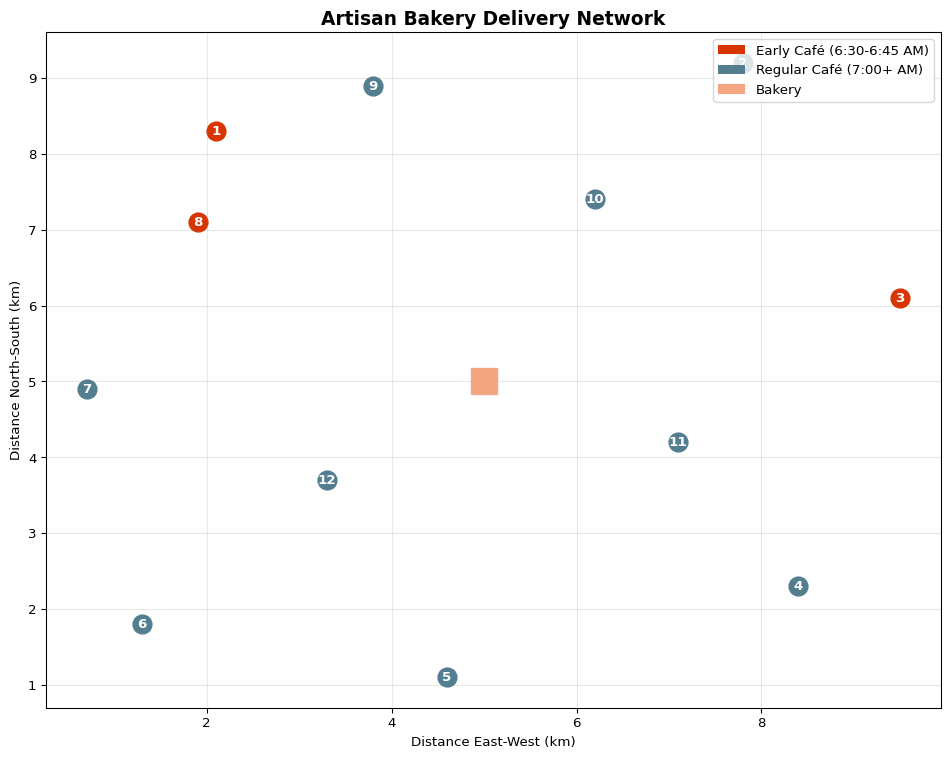

In [3]:
def visualize_route(route, cafe_info, bakery_loc, title="Delivery Route"):
    """Visualize the delivery route on a map."""
    plt.figure(figsize=(10, 8))

    # Plot cafés
    for _, cafe in cafe_info.iterrows():
        color = '#D73502' if cafe['time_window'] == 'EARLY' else '#537E8F'
        plt.scatter(cafe['x'], cafe['y'], s=200, c=color, zorder=3)
        plt.annotate(f"{cafe['cafe_id']}", (cafe['x'], cafe['y']),
                    ha='center', va='center', color='white', fontweight='bold')

    # Plot bakery
    plt.scatter(bakery_loc[0], bakery_loc[1], s=400, c='#F4A582',
               marker='s', zorder=3, label='Bakery')

    # Plot route if provided
    if route:
        route_x = [bakery_loc[0]]
        route_y = [bakery_loc[1]]
        for cafe_id in route:
            cafe = cafe_info.iloc[cafe_id - 1]
            route_x.append(cafe['x'])
            route_y.append(cafe['y'])
        route_x.append(bakery_loc[0])
        route_y.append(bakery_loc[1])

        plt.plot(route_x, route_y, 'o-', color='gray', linewidth=2,
                markersize=0, alpha=0.6)

        # Add route order annotations
        for i, cafe_id in enumerate(route, 1):
            cafe = cafe_info.iloc[cafe_id - 1]
            plt.annotate(f"#{i}", (cafe['x'], cafe['y']),
                        xytext=(10, 10), textcoords='offset points',
                        fontsize=8, color='black')

    plt.xlabel('Distance East-West (km)')
    plt.ylabel('Distance North-South (km)')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#D73502', label='Early Café (6:30-6:45 AM)'),
        Patch(facecolor='#537E8F', label='Regular Café (7:00+ AM)'),
        Patch(facecolor='#F4A582', label='Bakery')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

# Show the initial problem
visualize_route([], cafe_info, bakery_location, "Artisan Bakery Delivery Network")

## Your Task

### Required Implementation

Using the provided data and helper functions, implement:

1.  **Construction Algorithm** (choose one or try multiple):
    -   Nearest Neighbor (start from bakery)
    -   Nearest Neighbor with early cafés first
    -   Your own creative approach
2.  **Improvement Algorithm**:
    -   2-opt local search
    -   Or another improvement method
3.  **Time Window Handling**:
    -   Ensure early cafés are visited before their opening times
    -   You may need to modify your algorithm to prioritize these

### Template Code Structure

In [4]:
# YOUR SOLUTION CODE HERE

def build_initial_route(distance_matrix, cafe_info):
    """
    Build an initial route using your chosen method.

    Args:
        distance_matrix: Distance matrix (13x13, index 0 is bakery)
        cafe_info: DataFrame with café information

    Returns:
        List of café IDs in visit order (1-12)
    """
    # YOUR IMPLEMENTATION
    pass

def improve_route(route, distance_matrix, cafe_info):
    """
    Improve the route using local search.

    Args:
        route: Initial route
        distance_matrix: Distance matrix
        cafe_info: DataFrame with café information

    Returns:
        Improved route
    """
    # YOUR IMPLEMENTATION
    pass

# Build and improve your solution
initial_route = build_initial_route(distance_matrix, cafe_info)
final_route = improve_route(initial_route, distance_matrix, cafe_info)

# Calculate metrics
initial_distance = calculate_route_distance(initial_route, distance_matrix)
final_distance = calculate_route_distance(final_route, distance_matrix)
violations = check_time_windows(final_route, distance_matrix, cafe_info)

# Display results
print("SOLUTION SUMMARY")
print("=" * 60)
print(f"Initial route distance: {initial_distance:.2f} km")
print(f"Final route distance: {final_distance:.2f} km")
print(f"Improvement: {initial_distance - final_distance:.2f} km ({(initial_distance - final_distance)/initial_distance*100:.1f}%)")
print(f"\nTime window violations: {len(violations)}")
if violations:
    for v in violations:
        print(f"  - {v['cafe']}: {v['late_by']} minutes late")

print(f"\nEstimated costs:")
print(f"  Fuel: €{final_distance * 1.80:.2f}")
print(f"  Labor: €{(final_distance/40 + 0.2) * 35:.2f}")  # 0.2 hours for deliveries
print(f"  Penalties: €{len(violations) * 50:.2f}")
print(f"  TOTAL: €{final_distance * 1.80 + (final_distance/40 + 0.2) * 35 + len(violations) * 50:.2f}")

# Visualize solution
visualize_route(final_route, cafe_info, bakery_location,
               f"Optimized Route: {final_distance:.2f} km")

## Deliverables

### 1. Code File

Submit your completed code with: - Your construction algorithm - Your
improvement algorithm - Clear comments explaining your approach - Final
route and distance

### 2. One-Slide Presentation (PDF)

Create a single slide containing:

**Title:** Team Name - Artisan Bakery Route Optimization

**Content:** - **Route visualization** (map showing your solution) -
**Key metrics:** - Total distance: \_\_\_ km - Time window compliance: ✓
or ✗ for each early café - Daily cost: €*** - **Method summary** (2-3
bullets): - Construction approach used - Improvement method applied -
Special handling for time windows - **Business impact:** - Daily
savings: €*** - Annual savings: €\_\_\_

### 3. Presentation Preparation

Be ready to present (3 minutes): 1. **Problem understanding** (30 sec):
What makes this challenging? 2. **Solution approach** (1 min): How did
you tackle it? 3. **Results** (1 min): Distance, costs, time compliance
4. **Key insight** (30 sec): What surprised you or what would you
recommend?

## Evaluation Rubric

### Technical (60%)

-   **Algorithm correctness** (20%): Does it produce valid routes?
-   **Solution quality** (20%): How good is your distance?
-   **Time window handling** (20%): Do early cafés get deliveries on
    time?

### Analysis (25%)

-   **Metrics calculation** (10%): Accurate costs and times
-   **Improvement achieved** (10%): How much better than initial?
-   **Code clarity** (5%): Well-commented and organized

### Presentation (15%)

-   **Visualization quality** (5%): Clear route display
-   **Communication** (5%): Can the baker understand your solution?
-   **Business focus** (5%): Emphasis on practical impact

## Competition Tips

### Strategy Suggestions

1.  **Quick Win:** Start with nearest neighbor, it’s simple and often
    good enough

2.  **Time Windows First:** Consider visiting early cafés first, even if
    slightly suboptimal

3.  **Multiple Attempts:** Try different starting strategies:

    -   Start with closest early café
    -   Start with furthest early café
    -   Regular nearest neighbor then adjust

4.  **Improvement Focus:** Even basic 2-opt can save 10-20% distance

5.  **Validation:** Always check time windows! A shorter route that’s
    late is worse than a longer route on time.

### Common Pitfalls to Avoid

-   ❌ Forgetting to return to bakery
-   ❌ Not checking time windows until the end
-   ❌ Over-optimizing distance at the expense of deadlines
-   ❌ Starting from a café instead of the bakery
-   ❌ Not testing your solution with the provided check functions

### Hints from the Master Baker

*“The early bird cafés are my premium clients - they pay 20% more for
early delivery. I’d rather drive an extra kilometer than be late to
them!”*

*“My current driver always does the early cafés first, then figures out
the rest. Maybe he’s onto something?”*

*“Sometimes the ‘shortest’ route isn’t the best route when you factor in
traffic patterns and delivery windows.”*

## Good Luck!

Remember: The goal is a **practical solution** that the bakery can
actually use tomorrow morning. Perfect optimization is less important
than reliable, on-time delivery!

**Time Limit:** 60 minutes in class (continue development at home if
needed)

**May the best route win!** 🥐🚚